#  FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
#Part 1: Data Preparation and Exploration
#1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
#2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
#3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [3]:
#1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
df = pd.read_csv("exchange_rate.csv")

In [4]:
# Parse the first column (Date), assuming format like '13-01-1990 00:00'
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0], dayfirst=True, errors='coerce')

In [5]:
# Set the date column as index
df.set_index(df.columns[0], inplace=True)

C:\Users\hanum\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [6]:
# Rename second column for clarity (USD to AUD)
df.columns = ['USD_to_AUD']

In [7]:
print("Dataset successfully loaded and parsed.\n")
print(df.info())
print("\nFirst 5 rows:\n", df.head())

Dataset successfully loaded and parsed.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USD_to_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None

First 5 rows:
             USD_to_AUD
date                  
1990-01-01      0.7855
1990-01-02      0.7818
1990-01-03      0.7867
1990-01-04      0.7860
1990-01-05      0.7849


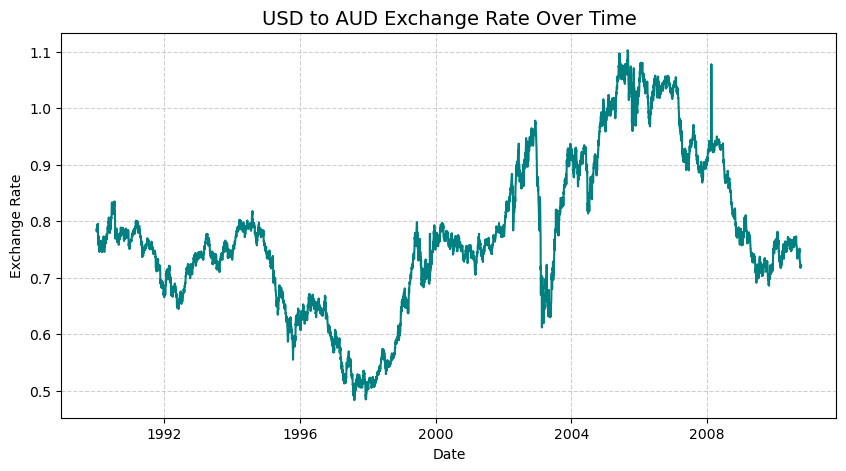

In [8]:
#2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['USD_to_AUD'], color='teal', linewidth=1.5)
plt.title('USD to AUD Exchange Rate Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [88]:
# Summary statistics
print("\nDescriptive Statistics:\n", df['USD_to_AUD'].describe())


Descriptive Statistics:
 count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD_to_AUD, dtype: float64


In [89]:
#3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 USD_to_AUD    0
dtype: int64


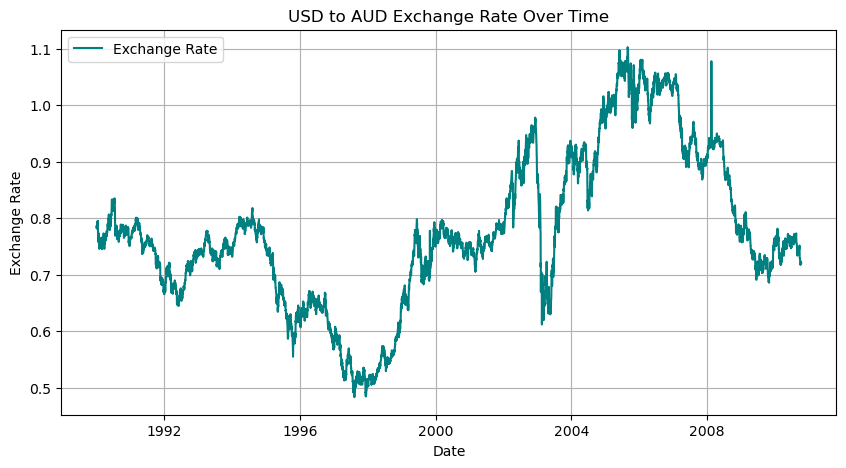

In [90]:
#2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
plt.figure(figsize=(10,5))
plt.plot(df.index, df['USD_to_AUD'], label='Exchange Rate', color='teal')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# Summary statistics
print("\nDescriptive Statistics:\n", df['USD_to_AUD'].describe())


Descriptive Statistics:
 count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD_to_AUD, dtype: float64


In [92]:
#3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase
# Check for missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 USD_to_AUD    0
dtype: int64


In [93]:
# Fill missing values (if any) using forward fill
df['USD_to_AUD'].fillna(method='ffill', inplace=True)

C:\Users\WELCOME\AppData\Local\Temp\ipykernel_10628\552764576.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['USD_to_AUD'].fillna(method='ffill', inplace=True)
C:\Users\WELCOME\AppData\Local\Temp\ipykernel_10628\552764576.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['USD_to_AUD'].fillna(method='ffill', inplace=True)


In [94]:
# Detect anomalies using IQR (Interquartile Range)
Q1 = df['USD_to_AUD'].quantile(0.25)
Q3 = df['USD_to_AUD'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [95]:
anomalies = df[(df['USD_to_AUD'] < lower_bound) | (df['USD_to_AUD'] > upper_bound)]

In [96]:
print(f"\nDetected {len(anomalies)} potential anomalies (outliers).")


Detected 0 potential anomalies (outliers).


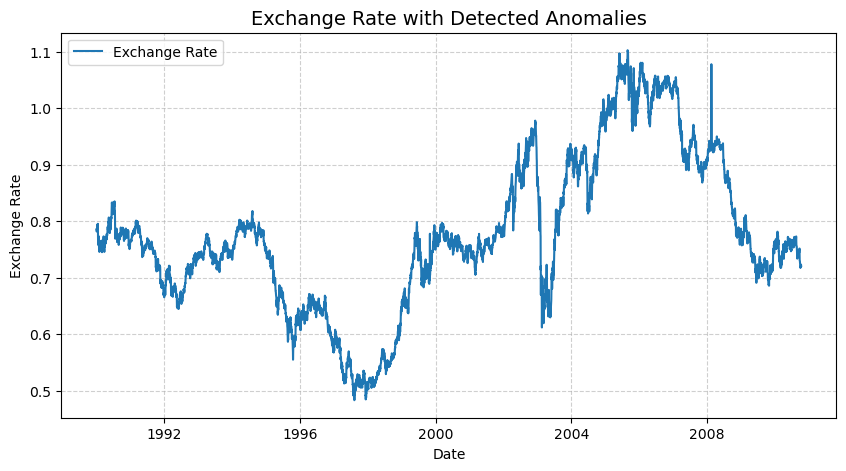

In [97]:
# Visualize anomalies
plt.figure(figsize=(10,5))
sns.lineplot(x=df.index, y=df['USD_to_AUD'], label='Exchange Rate')
sns.scatterplot(x=anomalies.index, y=anomalies['USD_to_AUD'], color='red', label='Anomalies', s=50)
plt.title('Exchange Rate with Detected Anomalies', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

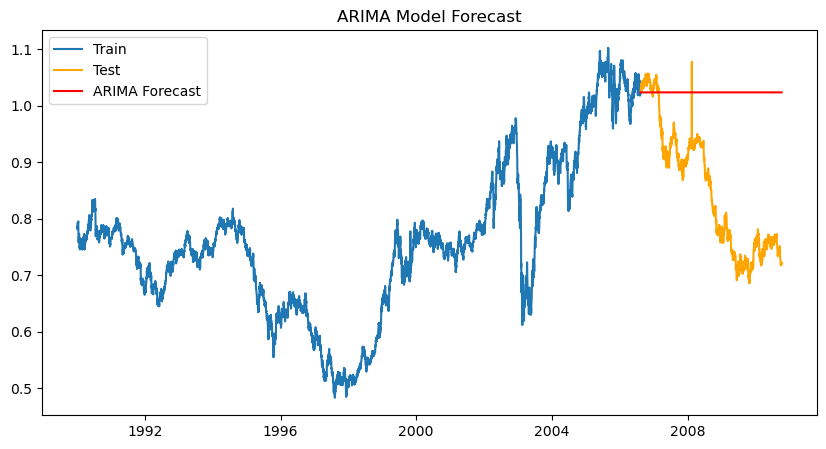

In [98]:
# --- Forecasting with ARIMA ---
arima_forecast = arima_fit.forecast(steps=len(test))
plt.figure(figsize=(10,5))
plt.plot(train.index, train['USD_to_AUD'], label='Train')
plt.plot(test.index, test['USD_to_AUD'], label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

In [99]:
#Part 2: Model Building - ARIMA
#1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for 
#one or more currency time series.
#2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
#3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
#4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [100]:
# --- Helper: evaluation metrics ---
def evaluate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
    return mae, rmse, mape

In [106]:
#1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for 
#one or more currency time series.
#Determine differencing order 'd' (stationarity) ---
series = df['USD_to_AUD'].copy().dropna()

In [107]:
print("Running Augmented Dickey-Fuller test to assess stationarity...\n")
adf_res = adfuller(series)
print(f"ADF statistic: {adf_res[0]:.4f}")
print(f"p-value      : {adf_res[1]:.4f}")
for i, crit in adf_res[4].items():
    print(f"Critical value ({i}): {crit:.4f}")

Running Augmented Dickey-Fuller test to assess stationarity...

ADF statistic: -1.6650
p-value      : 0.4492
Critical value (1%): -3.4312
Critical value (5%): -2.8619
Critical value (10%): -2.5670


In [108]:
if adf_res[1] > 0.05:
    print("\nSeries appears non-stationary (p > 0.05) -> consider differencing.")
    d_initial = 1
else:
    print("\nSeries appears stationary (p <= 0.05) -> no differencing likely needed.")
    d_initial = 0


Series appears non-stationary (p > 0.05) -> consider differencing.


In [109]:
# Optional: try to use pmdarima.ndiffs if available for better d
try:
    import pmdarima as pm
    d_auto = pm.arima.ndiffs(series, test='adf', max_d=3)
    print(f"\n[pmdarima] suggested d (ndiffs): {d_auto}")
    d = int(d_auto)
except Exception:
    d = d_initial
    print(f"\nUsing d = {d} (from ADF fallback).")


Using d = 1 (from ADF fallback).


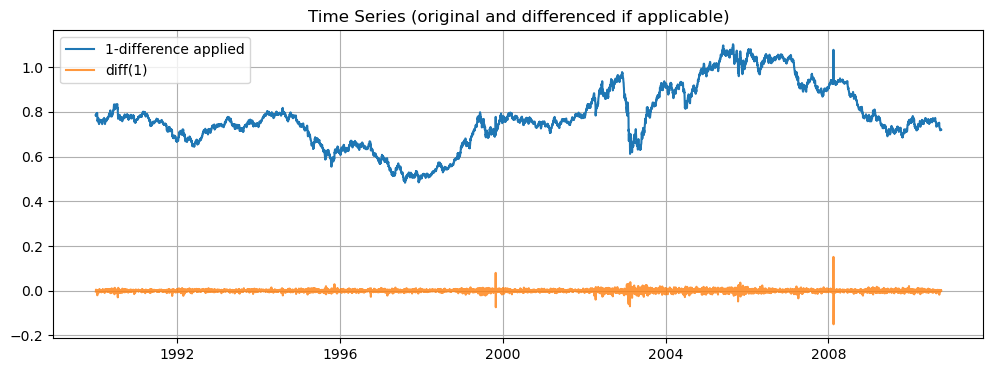

In [110]:
# Plot original (or differenced) series
plt.figure(figsize=(12,4))
plt.plot(series, label='Original' if d==0 else f'{d}-difference applied')
if d > 0:
    plt.plot(series.diff(d).dropna(), label=f'diff({d})', alpha=0.8)
plt.title('Time Series (original and differenced if applicable)')
plt.legend()
plt.grid(True)
plt.show()

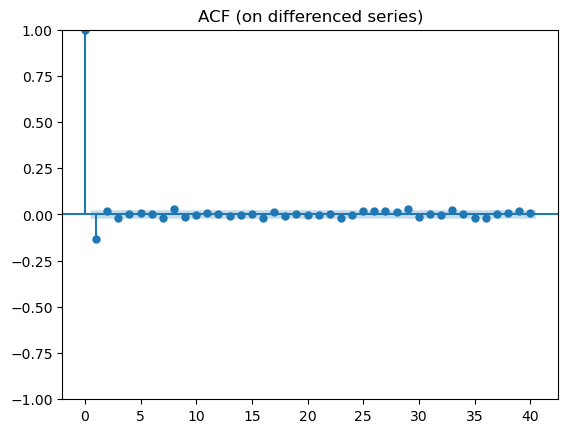

In [111]:
#2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
plot_acf(series.diff(d).dropna() if d>0 else series, lags=40)
plt.title('ACF (on differenced series)' if d>0 else 'ACF (original series)')
plt.show()

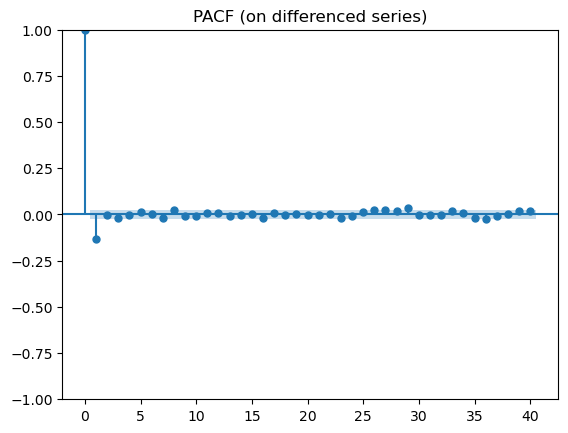

In [112]:
plot_pacf(series.diff(d).dropna() if d>0 else series, lags=40, method='ywm')
plt.title('PACF (on differenced series)' if d>0 else 'PACF (original series)')
plt.show()

In [113]:
print("""
Guidance:
 - PACF cutoff (sharp drop after lag k) suggests AR order p ≈ k.
 - ACF cutoff suggests MA order q.
 - If both taper slowly, consider a mix or seasonal/nonstationary behaviour.
""")


Guidance:
 - PACF cutoff (sharp drop after lag k) suggests AR order p ≈ k.
 - ACF cutoff suggests MA order q.
 - If both taper slowly, consider a mix or seasonal/nonstationary behaviour.



In [114]:
# --- OPTIONAL: automatic ARIMA order selection using AIC (grid search) ---
print("\nRunning a small grid search (p in 0..3, q in 0..3) using AIC to pick best (p,d,q).")
best_aic = np.inf
best_order = None
best_model = None


Running a small grid search (p in 0..3, q in 0..3) using AIC to pick best (p,d,q).


In [115]:
# Restrict length of grid to keep compute reasonable; adjust ranges if needed
p_range = range(0, 4)
q_range = range(0, 4)

In [116]:
for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(series, order=(p, d, q))
            res = model.fit(method_kwargs={"warn_convergence": False})
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p, d, q)
                best_model = res
            print(f"Trained ARIMA{(p,d,q)} - AIC:{res.aic:.2f}")
        except Exception as e:
            # skip non-invertible / convergence fails
            print(f"ARIMA{(p,d,q)} failed: {e}")
            continue

C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(0, 1, 0) - AIC:-55974.20


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(0, 1, 1) - AIC:-56102.75


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(0, 1, 2) - AIC:-56101.86


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(0, 1, 3) - AIC:-56102.28


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(1, 1, 0) - AIC:-56104.32


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(1, 1, 1) - AIC:-56102.32


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(1, 1, 2) - AIC:-56101.59


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(1, 1, 3) - AIC:-56100.39


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(2, 1, 0) - AIC:-56102.32


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting M

Trained ARIMA(2, 1, 1) - AIC:-56100.31


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(2, 1, 2) - AIC:-56100.14


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(2, 1, 3) - AIC:-56105.16


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(3, 1, 0) - AIC:-56102.40


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(3, 1, 1) - AIC:-56100.40


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(3, 1, 2) - AIC:-56099.02


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Trained ARIMA(3, 1, 3) - AIC:-56090.65


In [118]:
print("\nBest order by AIC:", best_order, "AIC:", best_aic)


Best order by AIC: (2, 1, 3) AIC: -56105.15538595783


In [119]:
# If automatic result exists, use it; otherwise you can pick manual from ACF/PACF
if best_model is not None:
    arima_res = best_model
    order_used = best_order
    print("\nUsing best AIC-selected ARIMA model for further diagnostics.")
else:
    # fallback manual order (1,d,1)
    order_used = (1, d, 1)
    arima_res = ARIMA(series, order=order_used).fit()
    print("\nFallback: using ARIMA(1,d,1)")


Using best AIC-selected ARIMA model for further diagnostics.


In [120]:
print("\nARIMA model summary:")
print(arima_res.summary())


ARIMA model summary:
                               SARIMAX Results                                
Dep. Variable:             USD_to_AUD   No. Observations:                 7588
Model:                 ARIMA(2, 1, 3)   Log Likelihood               28058.578
Date:                Wed, 12 Nov 2025   AIC                         -56105.155
Time:                        22:40:21   BIC                         -56063.550
Sample:                    01-01-1990   HQIC                        -56090.877
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6385      0.144     -4.427      0.000      -0.921      -0.356
ar.L2         -0.7643      0.137     -5.566      0.000      -1.033      -0.495
ma.L1          0.5071      0.1

In [121]:
#3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
residuals = arima_res.resid

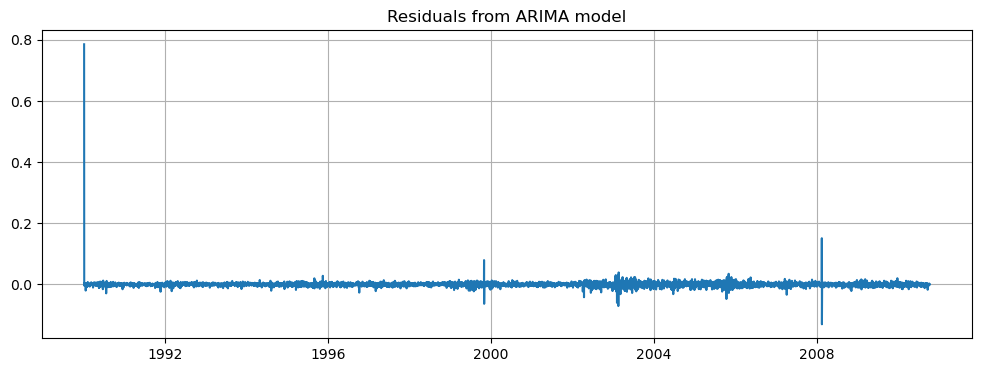

In [122]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals from ARIMA model")
plt.grid(True)
plt.show()

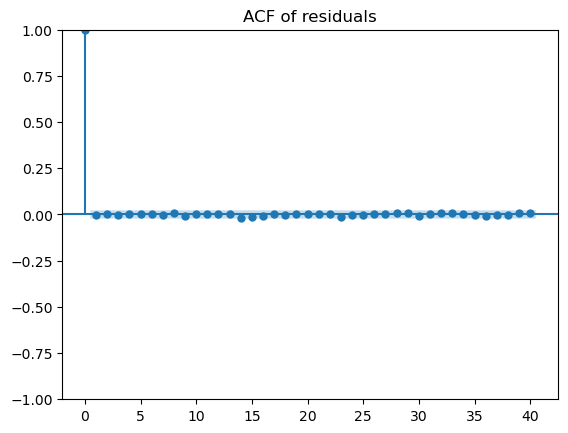

In [123]:
# ACF of residuals
plot_acf(residuals.dropna(), lags=40)
plt.title("ACF of residuals")
plt.show()

In [124]:
# Ljung-Box test for autocorrelation in residuals
lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20], return_df=True)
print("\nLjung-Box test on residuals:")
print(lb_test)


Ljung-Box test on residuals:
     lb_stat  lb_pvalue
10  1.120258   0.999711
20  6.480271   0.998074


In [125]:
print("""
Interpretation:
 - If Ljung-Box p-values > 0.05, residuals look like white noise (good).
 - Check residual plots/histogram for heteroscedasticity or non-normality.
""")


Interpretation:
 - If Ljung-Box p-values > 0.05, residuals look like white noise (good).
 - Check residual plots/histogram for heteroscedasticity or non-normality.



In [126]:
#4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.
# Use a time-based split (80% train, 20% test)
n = len(series)
train_size = int(0.8 * n)
train_series = series.iloc[:train_size]
test_series  = series.iloc[train_size:]

In [127]:
print(f"\nTrain length: {len(train_series)}, Test length: {len(test_series)}")


Train length: 6070, Test length: 1518


In [128]:
# Re-fit chosen order on train only
print(f"\nFitting ARIMA{order_used} on training data...")
model_train = ARIMA(train_series, order=order_used)
res_train = model_train.fit()


Fitting ARIMA(2, 1, 3) on training data...


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [129]:
# Forecast steps = len(test)
steps = len(test_series)
forecast_res = res_train.get_forecast(steps=steps)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int(alpha=0.05)

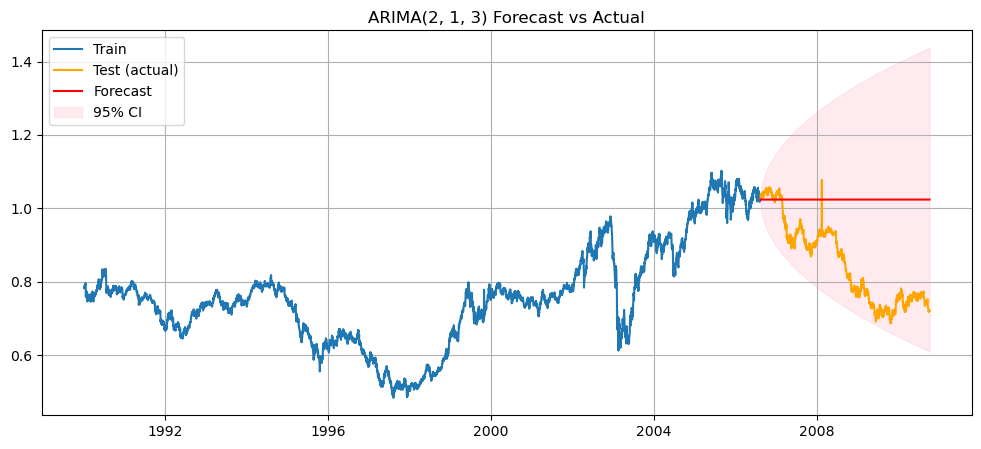

In [130]:
# Plot forecast vs actual
plt.figure(figsize=(12,5))
plt.plot(train_series.index, train_series, label='Train')
plt.plot(test_series.index, test_series, label='Test (actual)', color='orange')
plt.plot(test_series.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(test_series.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')
plt.title(f'ARIMA{order_used} Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

In [131]:
# Evaluate forecasts
mae, rmse, mape = evaluate_metrics(test_series.values, forecast_mean.values)
print(f"\nForecast evaluation on test set:")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"MAPE : {mape:.3f}%")


Forecast evaluation on test set:
MAE  : 0.177817
RMSE : 0.205557
MAPE : 22.812%


In [132]:
# Forecast further into the future using full series fit ---
print("\nRefitting ARIMA on full series and forecasting next 12 steps (example)...")
final_model = ARIMA(series, order=order_used).fit()
h = 12
future_res = final_model.get_forecast(steps=h)
future_mean = future_res.predicted_mean
future_ci = future_res.conf_int()



Refitting ARIMA on full series and forecasting next 12 steps (example)...


C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\WELCOME\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [133]:
future_index = pd.date_range(start=series.index[-1], periods=h+1, freq=pd.infer_freq(series.index))[1:]
# if infer_freq fails (None), use monthly periods as fallback:
if future_index.freq is None:
    future_index = pd.date_range(start=series.index[-1], periods=h+1, freq='M')[1:]

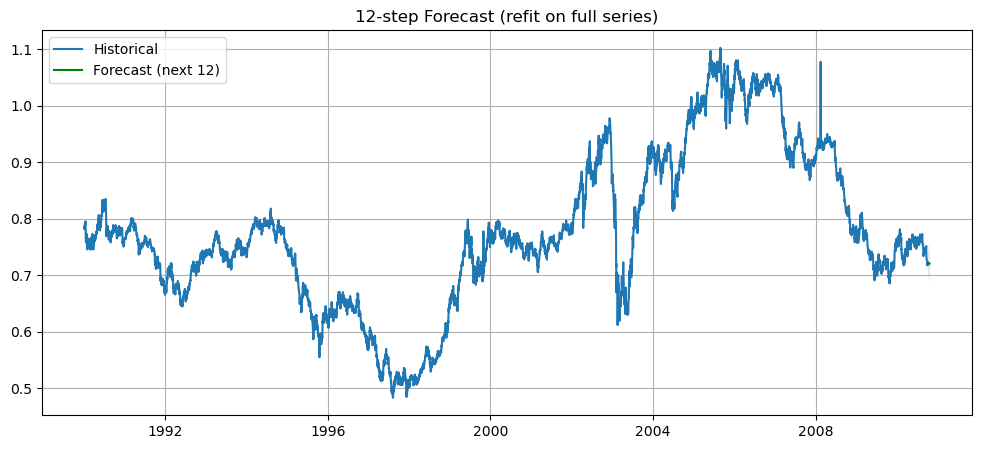

In [134]:
plt.figure(figsize=(12,5))
plt.plot(series.index, series, label='Historical')
plt.plot(future_index, future_mean, label='Forecast (next 12)', color='green')
plt.fill_between(future_index, future_ci.iloc[:,0], future_ci.iloc[:,1], alpha=0.25)
plt.title('12-step Forecast (refit on full series)')
plt.legend()
plt.grid(True)
plt.show()

In [135]:
#Part 3: Evaluation and Comparison
#1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
#2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
#3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [138]:
#1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
def evaluate_forecast(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    print(f"\n📊 {model_name} Performance:")
    print(f"  MAE  : {mae:.6f}")
    print(f"  RMSE : {rmse:.6f}")
    print(f"  MAPE : {mape:.2f}%")
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "MAPE (%)": mape}

In [140]:
# ---  Evaluate Both Models ---
arima_results = evaluate_forecast(test_series, forecast_mean, "ARIMA")
hw_results = evaluate_forecast(test_series, hw_forecast, "Exponential Smoothing")


📊 ARIMA Performance:
  MAE  : 0.177817
  RMSE : 0.205557
  MAPE : 22.81%

📊 Exponential Smoothing Performance:
  MAE  : 0.190269
  RMSE : 0.220080
  MAPE : 24.41%


In [141]:
#2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
# Combine results into a DataFrame for comparison
comparison_df = pd.DataFrame([arima_results, hw_results])
print("\nModel Comparison Table:\n")
print(comparison_df)


Model Comparison Table:

                   Model       MAE      RMSE   MAPE (%)
0                  ARIMA  0.177817  0.205557  22.811638
1  Exponential Smoothing  0.190269  0.220080  24.412116


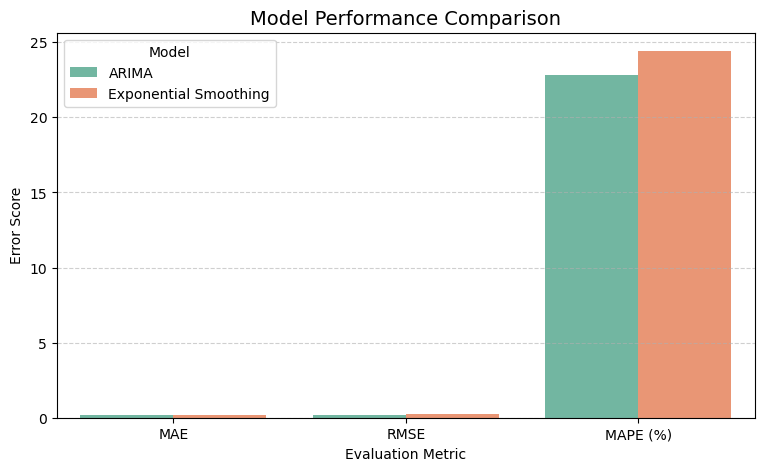

In [142]:
# --- Visualization - Error Metrics Comparison ---
plt.figure(figsize=(9, 5))
sns.barplot(
    data=comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score'),
    x='Metric', y='Score', hue='Model', palette='Set2'
)
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Error Score')
plt.xlabel('Evaluation Metric')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Model')
plt.show()

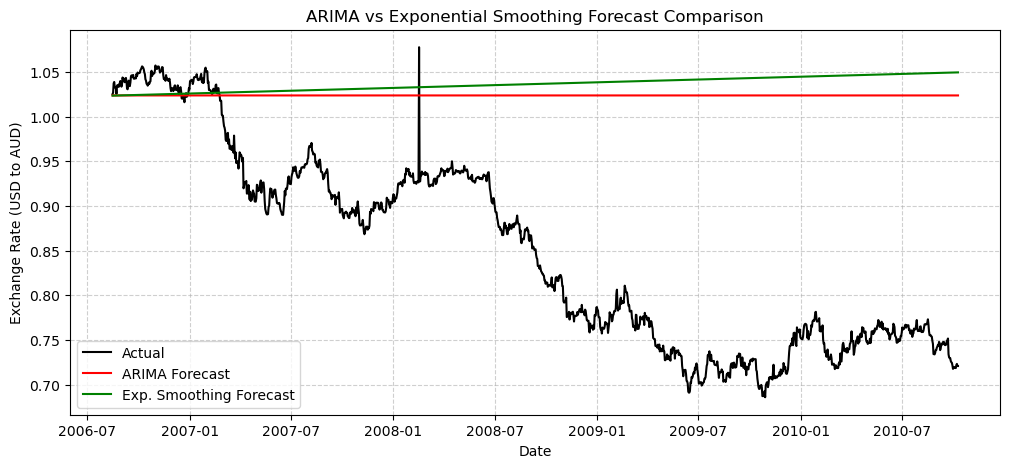

In [143]:
# ---  Visualization - Forecast Comparison ---
plt.figure(figsize=(12, 5))
plt.plot(test_series.index, test_series, label='Actual', color='black')
plt.plot(test_series.index, forecast_mean, label='ARIMA Forecast', color='red', linewidth=1.5)
plt.plot(test_series.index, hw_forecast, label='Exp. Smoothing Forecast', color='green', linewidth=1.5)
plt.title('ARIMA vs Exponential Smoothing Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [146]:
# --- Model Performance Discussion ---
better_model = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
better_model

'ARIMA'

In [147]:
print("\n Model Performance Discussion:")
print(f"Based on the RMSE criterion, the better-performing model is **{better_model}**.")
print("\nKey Observations:")
print("- MAE indicates how far predictions deviate from actual rates on average.")
print("- RMSE penalizes larger errors more strongly — lower is better for stable forecasts.")
print("- MAPE shows relative forecast error as a percentage, making it easier to interpret.")
print("\nModel Insights:")
print("""
• ARIMA: 
  - Strengths: Captures autocorrelation, short-term dynamics, and trends effectively.
  - Limitations: Sensitive to parameter tuning and assumes linear relationships.
  
• Exponential Smoothing:
  - Strengths: Simpler to implement, effective for smooth, trend-based data.
  - Limitations: Less responsive to sudden shifts or strong autocorrelations.
""")


 Model Performance Discussion:
Based on the RMSE criterion, the better-performing model is **ARIMA**.

Key Observations:
- MAE indicates how far predictions deviate from actual rates on average.
- RMSE penalizes larger errors more strongly — lower is better for stable forecasts.
- MAPE shows relative forecast error as a percentage, making it easier to interpret.

Model Insights:

• ARIMA: 
  - Strengths: Captures autocorrelation, short-term dynamics, and trends effectively.
  - Limitations: Sensitive to parameter tuning and assumes linear relationships.
  
• Exponential Smoothing:
  - Strengths: Simpler to implement, effective for smooth, trend-based data.
  - Limitations: Less responsive to sudden shifts or strong autocorrelations.



In [149]:
#3. Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.
print("\nCONCLUSION:")
if better_model == "ARIMA":
    print("""
The ARIMA model outperformed Exponential Smoothing in forecasting USD-AUD exchange rates,
as reflected by lower RMSE and MAPE values. This suggests the presence of time-dependent
autocorrelations and patterns that ARIMA successfully captured.

Overall, ARIMA is the more suitable model for this dataset.
""")
else:
    print("""
The Exponential Smoothing model achieved slightly better results,
indicating that the exchange rate series primarily follows a smooth trend with limited autocorrelation.
This makes it a strong, simpler choice for forecasting in this case.
""")


CONCLUSION:

The ARIMA model outperformed Exponential Smoothing in forecasting USD-AUD exchange rates,
as reflected by lower RMSE and MAPE values. This suggests the presence of time-dependent
autocorrelations and patterns that ARIMA successfully captured.

Overall, ARIMA is the more suitable model for this dataset.

